# Dataset Exploration and Shifts (dSprites)

This notebook explore the dSprites original and shifted version. We visualise and verify correctness of various shift.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.io
from math import ceil
from copy import deepcopy
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Mount drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Run utility functions
%run drive/MyDrive/Colab\ Notebooks/MPhil\ Prototype/Utilities.ipynb

## Loading dSprites

In this section, we will load and visualise the dSprite datasets.

In [59]:
# Load dataset, split into train test
path = 'drive/MyDrive/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
x_train, x_test, y_train, y_test, c_train, c_test = load_dsprites(path, 200000, train_size=0.85, class_index=1)

# Split training into validation set as well
x_train, x_valid = x_train[:150000], x_train[150000:]
y_train, y_valid = y_train[:150000], y_train[150000:]
c_train, c_valid = c_train[:150000], c_train[150000:]

Training samples: 170000
Testing samples: 30000


In [22]:
# Print class proportion
print("Train")
print(pd.DataFrame(y_train).value_counts())
print("****\n")

print("Validation")
print(pd.DataFrame(y_valid).value_counts())
print("****\n")

print("Test")
print(pd.DataFrame(y_test).value_counts())
print("****\n")

Train
1    50170
2    49983
0    49847
dtype: int64
****

Validation
2    6740
1    6630
0    6630
dtype: int64
****

Test
1    10068
0    10001
2     9931
dtype: int64
****



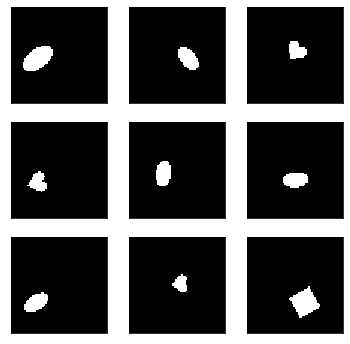

In [12]:
# Randomly sample some latents (from the dataset)
latents_sampled = sample_latent(size=49)

# Select images
imgs_sampled = x_train[:10].reshape(-1, 64, 64)

# Show images
show_images_grid(imgs_sampled, num_images=9)

## Shifts Applicator

In this section, we will apply various shifts to the data and visualise it.

In [61]:
# Reshape
# It is noteworthy that for efficiency, we represent the images as only 2 dimension
# when we preprocessing (number of instances/ batch size * flatten size).
# When visualising back the image, we need to reshape it back to the original dimension
ORIGINAL_SHAPE = x_train.shape[1:] # constant hold the image original shape
x_train_flatten = deepcopy(x_train.reshape(x_train.shape[0], -1))
x_valid_flatten = deepcopy(x_valid.reshape(x_valid.shape[0], -1))
x_test_flatten = deepcopy(x_test.reshape(x_test.shape[0], -1))

### Gaussian Noise

We apply gaussian noise to the image and observe the result.

#### Large Gaussian Shift

In [62]:
## Large gaussian shift (with delta = 1/ applied to full dataset)
shift = "large_gn_shift_1.0"
x_gaussian, y_gaussian = apply_shift(deepcopy(x_test_flatten), y_test, shift, ORIGINAL_SHAPE) 

Large GN shift


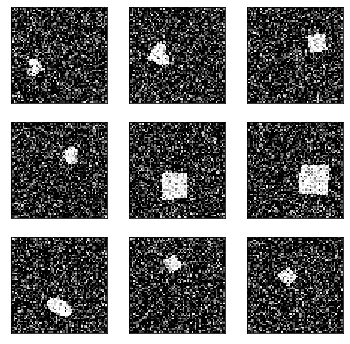

In [63]:
# Plot example of images after applying large gaussian shift to them
show_images_grid(x_gaussian.reshape([-1, 64, 64]), num_images=9)

#### Medium Gaussian Shift

In [65]:
## Medium gaussian shift (with delta = 1)
shift = "medium_gn_shift_1.0"
x_gaussian, y_gaussian = apply_shift(deepcopy(x_test_flatten), y_test, shift, ORIGINAL_SHAPE) 

Medium GN Shift


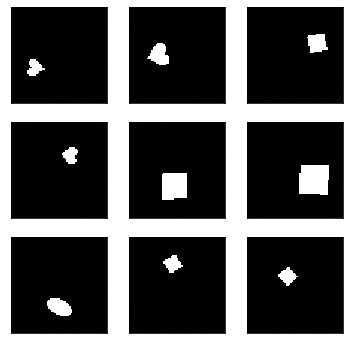

In [77]:
# Plot example of images after applying medium gaussian shift to them
show_images_grid(x_gaussian.reshape([-1, 64, 64]), num_images=9)

The noise is barely noticeable by human eye (but upon inspecting the array, the values have changed.

#### Small Gaussian Shift

In [73]:
## Medium gaussian shift (with delta = 1)
shift = "small_gn_shift_1.0"
x_gaussian, y_gaussian = apply_shift(deepcopy(x_test_flatten), y_test, shift, ORIGINAL_SHAPE) 

Small GN Shift


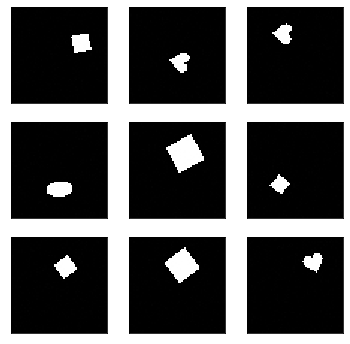

In [78]:
# Plot example of images after applying small gaussian shift to them
show_images_grid(x_test_flatten.reshape([-1, 64, 64])[np.random.randint(0, 2000, 50)], num_images=9)

The noise is barely noticeable by human eye (but upon inspecting the array, the values have changed.

### Knockout shift

We apply the knockout shift, which create class imbalance.

In [81]:
## Large gaussian shift (with delta = 1/ applied to full dataset)
shift = "ko_shift_1.0"
x_gaussian, y_gaussian = apply_shift(deepcopy(x_train_flatten), y_train, shift, ORIGINAL_SHAPE) 

Large knockout shift


In [82]:
pd.DataFrame(y_gaussian).value_counts()

1    50241
2    49900
dtype: int64

Class 0 is removed altogether by the knockout shift creating extreme class imbalance.

### Image Shift

we apply various image shift, including translation, rotation, zoom, horizontal flip, vertical flip.

In [92]:
## Large gaussian shift (with delta = 1/ applied to full dataset)
shift = "large_img_shift_1.0"
x_gaussian, y_gaussian = apply_shift(deepcopy(x_train_flatten), y_train, shift, ORIGINAL_SHAPE) 

Large image shift


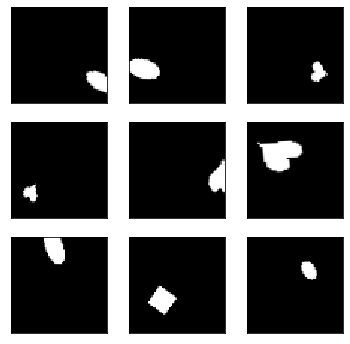

In [93]:
# Plot example of images after applying large image shift to them
show_images_grid(x_gaussian.reshape([-1, 64, 64])[np.random.randint(0, 2000, 50)], num_images=9)